In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

# Множественная регрессия

> Часть курса <a href="https://docs.microsoft.com/ru-ru/learn/modules/compare-two-samples-by-bootstrapping/">«Основы обработки и анализа данных»</a> от Microsoft с переработанными примерами под библиотеку `pandas`.

Прогнозирование числового количества называется регрессией, а широко применяемый метод использования нескольких атрибутов для регрессии называется _множественной линейной регрессией_.

## Цены на недвижимость

Приведенный ниже набор данных по ценам на недвижимость и другим параметрам собирался несколько лет в городе Эймс, штат Айова. Описание этого набора данных доступно в Интернете. Мы сосредоточимся лишь на подмножестве столбцов. Мы попробуем спрогнозировать продажную цену на основе других столбцов.

In [2]:
all_sales = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/house.csv')
sales = all_sales[(all_sales['Bldg Type'] == '1Fam' ) \
                        & (all_sales['Sale Condition'] == 'Normal')] \
                        .filter(['SalePrice', '1st Flr SF', '2nd Flr SF',
                                 'Total Bsmt SF', 'Garage Area',
                                 'Wood Deck SF', 'Open Porch SF', 'Lot Area',
                                 'Year Built', 'Yr Sold']) \
                        .sort_values(by='SalePrice')

sales

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
2843,35000,498,0,498.0,216.0,0,0,8088,1922,2006
1901,39300,334,0,0.0,0.0,0,0,5000,1946,2007
1555,40000,649,668,649.0,250.0,0,54,8500,1920,2008
708,45000,612,0,0.0,308.0,0,0,5925,1940,2009
1220,52000,729,0,270.0,0.0,0,0,4130,1935,2008
...,...,...,...,...,...,...,...,...,...,...
2450,584500,1933,1567,1733.0,959.0,870,86,17242,1993,2006
432,610000,2674,0,2630.0,762.0,360,50,13693,2007,2009
1063,615000,2470,0,2535.0,789.0,154,65,12720,2003,2008
2445,625000,1831,1796,1930.0,807.0,361,76,35760,1995,2006


Гистограмма продажных цен демонстрирует широкий разброс, что явно не нормально. Длинный хвост справа включает несколько домов с высокой ценой. Короткий хвост слева не содержит домов, которые были проданы более чем за $35 000.

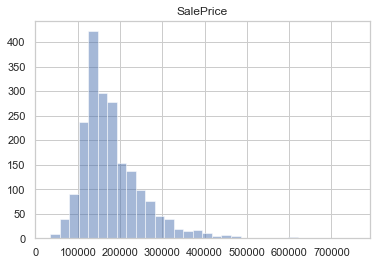

In [3]:
sales.hist('SalePrice', bins=32, alpha=.5);

## Корреляция
Ни одного атрибута самого по себе не достаточно для прогнозирования продажной цены. Например, площадь первого этажа в квадратных футах коррелируется с продажной ценой, но объясняет ее изменчивость лишь частично.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


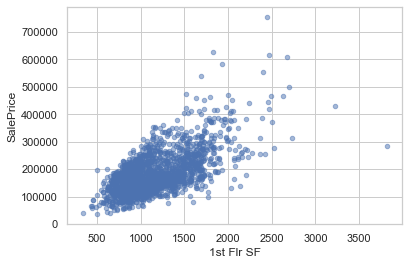

In [4]:
sales.plot('1st Flr SF', 'SalePrice', kind='scatter', alpha=.5);

In [5]:
np.corrcoef(sales['SalePrice'], sales['1st Flr SF'])[0][1]

0.6424662541030227

На самом деле ни один из атрибутов не имеет корреляции с продажной ценой, которая превышает 0,7 (за исключением самой продажной цены).

In [6]:
for label in sales.columns:
    r = np.corrcoef(sales['SalePrice'], sales[label])[0][1]
    print(f'Correlation of {label} and SalePrice {r}')

Correlation of SalePrice and SalePrice 1.0
Correlation of 1st Flr SF and SalePrice 0.6424662541030227
Correlation of 2nd Flr SF and SalePrice 0.35752189428008246
Correlation of Total Bsmt SF and SalePrice 0.6529786267571689
Correlation of Garage Area and SalePrice 0.638594485252044
Correlation of Wood Deck SF and SalePrice 0.35269866619504925
Correlation of Open Porch SF and SalePrice 0.33690941702637356
Correlation of Lot Area and SalePrice 0.29082345511576946
Correlation of Year Built and SalePrice 0.5651647537135916
Correlation of Yr Sold and SalePrice 0.025948579080721106


Однако сочетание атрибутов может дать более высокую корреляцию. В частности, если суммировать площадь первого и второго этажей, результат имеет более высокую корреляцию, чем любой отдельный атрибут.

In [7]:
both_floors = sales['1st Flr SF'] + sales['2nd Flr SF']
np.corrcoef(sales['SalePrice'], both_floors)[0][1]

0.7821920556134877

Такое повышение корреляции указывает на то, что мы должны попытаться использовать несколько атрибутов для прогнозирования продажной цены. В случае с набором данных с несколькими наблюдаемыми атрибутами и одним прогнозируемым числовым значением (в данном случае это продажная цена) множественная линейная регрессия может быть эффективным приемом.

## Множественная линейная регрессия
При использовании множественной линейной регрессии числовой результат прогнозируется исходя из входных числовых атрибутов путем умножения значения каждого атрибута на особое значение наклона и последующего суммирования результатов. В этом примере наклон для `1st Flr SF` представляет цену в долларах за квадратный фут на первом этаже дома, которую следует использовать при прогнозировании.

Прежде чем начать прогнозирование, мы разделим данные случайным образом на обучающий и проверочный наборы одинакового размера.

In [8]:
train, test = np.split(sales.sample(frac=1), [1001])
print(len(train), 'training and', len(test), 'test instances.')

1001 training and 1001 test instances.


Наклоны для нескольких регрессий представлены массивом, содержащим одно значение наклона для каждого атрибута в примере. Прогнозирование продажной цены подразумевает умножение каждого атрибута на наклон и суммирование результатов.

In [10]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('SalePrice', axis=1).iloc[0]
print('Predicting sale price for:', example_row)
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Predicting sale price for: 1st Flr SF        825.0
2nd Flr SF        587.0
Total Bsmt SF     780.0
Garage Area       280.0
Wood Deck SF       45.0
Open Porch SF       0.0
Lot Area         6000.0
Year Built       1939.0
Yr Sold          2009.0
Name: 736, dtype: float64
Using slopes: [ 9.39625243  9.07353007 11.32029574  9.72710701  8.64396034  9.08114554
 11.238889   11.11526344  8.46570656]
Result: 131013.90355763226


Результат представляет собой прогнозируемую продажную цену, которую можно сравнить с фактической ценой продажи, чтобы оценить точность наклонов для прогнозирования. Так как значения `example_slopes` были выбраны выше случайным образом, не следует рассчитывать на их точность.

In [11]:
print('Actual sale price:', test['SalePrice'].iloc[0])
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 132500
Predicted sale price using random slopes: 131013.90355763226


## Регрессия методом наименьших квадратов
Следующим шагом при выполнении множественной регрессии является определение цели наименьших квадратов. Мы выполняем прогнозирование для каждой строки в обучающем наборе, а затем вычисляем корень из среднеквадратической погрешности прогнозов на основе фактических цен.

In [12]:
train_prices = train['SalePrice']
train_attributes = train.drop('SalePrice', 1)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.iloc[i])
        actual = prices.iloc[i]
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 103170.71688277448


Наконец, мы используем функцию `minimize` из библиотеки `scipy.optimize` для поиска наклонов с самым низким значением корня из среднеквадратической погрешности. При использовании этого аргумента функции `minimize` также требуется выполнить начальное приближение наклонов, чтобы определить размер входного массива. Наконец, чтобы ускорить оптимизацию, мы указываем, что `rmse_train` является гладкой функцией, используя параметр `method='L-BFGS-B'`. Вычисление оптимальных наклонов может занять несколько минут.

In [13]:
from scipy.optimize import minimize
best_slopes = minimize(rmse_train, example_slopes, method='L-BFGS-B')

In [14]:
print('The best slopes for the training set:')
pd.DataFrame(best_slopes.x.reshape((1, -1)), columns=train_attributes.columns)

The best slopes for the training set:


,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
0,77.884422,77.824936,52.454817,42.492216,39.28427,10.472643,0.486435,496.608177,-496.78762


In [15]:
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes.x))

RMSE of all training examples using the best slopes: 33380.80640780364


## Интерпретация множественной регрессии
Давайте интерпретируем эти результаты. Оптимальные наклоны позволяют спрогнозировать цену на дом, исходя из его параметров. Квадратный фут на первом этаже стоит примерно 78 (первый наклон), а на втором — 78 (второй наклон). Окончательное отрицательное значение описывает ситуацию на рынке: цены со временем в среднем снижались.

Корень из среднеквадратической погрешности, равный примерно 34 000 долларов, означает, что наилучший линейный прогноз продажной цены на основе всех атрибутов имеет отклонение в обучающем наборе в среднем в 17 000 долларов. При прогнозировании цен на основе проверочного набора погрешность такая же. Это означает, что наш метод прогнозирования можно распространить на другие выборки из той же популяции.

In [16]:
test_prices = test['SalePrice']
test_attributes = test.drop('SalePrice', 1)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes.x)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 28653.367208395


Если бы прогнозы были идеальными, то точечная диаграмма прогнозируемых и фактических значений была бы прямой линией с наклоном 1. Мы видим, что большинство точек находятся рядом с этой линией, но в прогнозах есть погрешность.

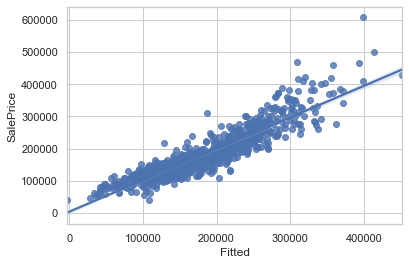

In [17]:
def fit(row):
    return sum(best_slopes.x * row)

test['Fitted'] = test_attributes.apply(fit, axis=1)
sns.regplot(data=test, x='Fitted', y='SalePrice');

Диаграмма остатков для множественной регрессии обычно позволяет сравнивать погрешности (остатки) с фактическими значениями прогнозируемой переменной. На диаграмме остатков ниже видно, что мы систематически недооценивали дома с высокой стоимостью, на что указывает множество положительных значений остатков в правой части диаграммы.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


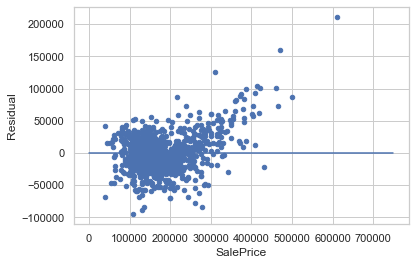

In [19]:
test['Residual'] = test_prices - test_attributes.apply(fit, axis=1)
test.plot('SalePrice', 'Residual', kind='scatter')
plt.plot([0, 7.5e5], [0, 0]);

Как и в случае с простой линейной регрессией, интерпретация результата прогноза не менее, а то и более важна, чем само прогнозирование. Существует множество уроков по интерпретации результатов множественной регрессии, которые не включены в этот учебник. После завершения этого модуля естественным следующим шагом будет более глубокое изучение линейного моделирования и регрессии.

## Ближайшие соседи для регрессии
Другой подход к прогнозированию продажной цены дома заключается в использовании цен на похожие дома. Такой метод _ближайших соседей_ очень похож на наш классификатор. Чтобы ускорить вычисления, мы будем использовать только те атрибуты, которые имели максимальную корреляцию с продажной ценой в исходном анализе.



In [20]:
predictors = train.columns[[0, 1, 2, 3, 4, 8]]
train_nn = train[predictors]
test_nn = test[predictors]
train_nn

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
1809,181000,1486,0,1461.0,566.0,2006
841,138000,990,0,990.0,480.0,1994
2782,157500,686,702,675.0,317.0,1977
1547,120500,816,0,816.0,432.0,1930
1287,111000,680,680,680.0,330.0,1910
...,...,...,...,...,...,...
2659,163000,880,888,880.0,320.0,1914
88,127000,1040,0,1040.0,260.0,1962
2122,175000,646,662,635.0,497.0,1997
309,254900,1036,880,1049.0,741.0,1998


Вычисление ближайших соседей идентично классификатору ближайших соседей. В этом случае мы исключим столбец `'SalePrice'`, а не `'Class'` из вычисления расстояния. Ниже приведены пять ближайших соседей первой проверочной строки.

In [21]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output, axis=1)
    for index, row in attributes.iterrows():
        dists.append(row_distance(row, example))
    res = training.copy()
    res['Distance'] = dists
    return res

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort_values(by='Distance').take(np.arange(k))

In [22]:
example_nn_row = test_nn.drop('SalePrice', axis=1).iloc[0]
closest(train_nn, example_nn_row, 5, 'SalePrice')

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
1531,149000,851,651,776.0,270.0,1931,70.370448
705,129500,768,560,768.0,308.0,1950,70.901340
197,139900,780,636,780.0,312.0,1948,74.370693
1510,135500,872,521,816.0,300.0,1955,92.287594
2693,119500,780,596,780.0,198.0,1937,93.989361


In [23]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice')['SalePrice'])

predict_nn(example_nn_row)

134680.0

In [24]:
print('Actual sale price:', test_nn.loc[0, 'SalePrice'])
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 215000
Predicted sale price using nearest neighbors: 134680.0


## Оценка
Чтобы оценить эффективность этого подхода применительно ко всему проверочному набору, мы применим `predict_nn` к каждому проверочному примеру, а затем вычислим корень из среднеквадратической погрешности прогнозов. Вычисление прогнозов может занять несколько минут.

In [25]:
nn_test_predictions = test_nn.drop('SalePrice', axis=1).apply(predict_nn, axis=1)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  28653.367208395
Test set RMSE for nearest neighbor regression: 30609.863564333853


Для этих данных погрешности при использовании двух методов похожи! Для других наборов данных один из методов может быть эффективнее другого. Вычисляя корень из среднеквадратической погрешности для обоих методов, можно объективно сравнить их эффективность при применении к одним и тем же данным. Важное предостережение: разница в эффективности может быть не связана с самим методом. Она может быть обусловлена случайными отклонениями при выборе обучающего и проверочного наборов.

Наконец, можно построить диаграмму остатков для этих прогнозов. Мы по-прежнему недооцениваем цены на самые дорогие дома, но это отклонение больше не является систематическим. Однако меньшее число остатков близко к нулю, что свидетельствует о том, что меньшее количество цен было предсказано с высокой точностью.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


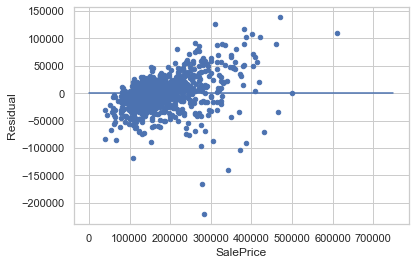

In [27]:
test['Residual'] = test_prices - nn_test_predictions
test.plot('SalePrice', 'Residual', kind='scatter')
plt.plot([0, 7.5e5], [0, 0]);

# Моделирование распределения коэффициентов регрессии

## Анализ для регрессии

До сих пор наш анализ связи между переменными был исключительно описательным. Мы понимаем, как найти лучшую прямую линию для проведения на точечной диаграмме. Линия является наилучшей в том смысле, что она имеет наименьшую среднюю квадратную ошибку оценки из всех прямых линий.

Но что делать, если наши данные были только выборкой из более крупной совокупности данных? Если в выборке мы обнаружили линейную связь между двумя переменными, будет ли то же справедливо для совокупности данных в целом? Будет ли это точно такое же линейное отношение? Можно ли предсказать ответ нового лица, которого нет в нашей выборке?

Такие вопросы, связанные с анализом и прогнозированием, возникают, если мы считаем, что точечная диаграмма отражает базовую связь между двумя отслеживаемыми на ней переменными, но не указывает их отношение полностью. Например, точечная диаграмма с весом рождения по сравнению с днями беременности показывает точное отношение между двумя переменными в нашей выборке. Но может возникнуть вопрос, будет ли это отношение верным или почти верным, для всех детей в группе, из которой была взята выборка, или для детей вообще.

Как всегда, логические выводы начинаются с тщательного изучения допущений относительно данных. Наборы допущений называются _моделями_. Наборы допущений о случайности в приблизительно линейных точечных диаграммах называются _регрессионными моделями_.

## Регрессионная модель
Вкратце, такие модели означают, что базовое отношение между двумя переменными является идеально линейным. Такая прямая линия — это *сигнал*, который мы хотели бы выявить. Тем не менее линия не видна нам четко. То, что мы видим, — это точки, которые разбросаны вокруг линии. В каждой точке сигнал засорен *случайными шумами*. Поэтому цель нашего анализа заключается в том, чтобы отделить сигнал от шума.

Если подробнее, регрессионная модель указывает, что точки на точечной диаграмме создаются случайным образом, как показано ниже.

- Отношение между $x$ и $y$ является идеально линейным. Мы не видим эту "истинную линию", но она существует.
- Точечная диаграмма создается путем создания точек на линии и их вертикального смещения относительно линии, выше или ниже, как показано тут:
  - Для каждого $x$ найдите соответствующую точку на истинной линии (это сигнал), а затем создайте шум или ошибку.
  - Ошибки выводятся случайным образом с заменой из совокупности ошибок, у которой имеется нормальное распределение со средним значением 0.
  - Создайте точку, горизонтальной координатой которой является $x$, а вертикальной координатой — "высота истинной строки в $x$ плюс ошибка".
- Наконец, удалите из точечной диаграммы истинную линию, чтобы отражались только созданные точки.

Как следует оценивать истинную линию, основываясь на этой точечной диаграмме? Наилучшей линией, которую можно провести по точечной диаграмме, является линия регрессии. Поэтому линия регрессии является естественной оценкой истинной линии.

В приведенной ниже модели показано, насколько близка линия регрессии к реальной линии. На первой панели показано, как из реальной линии создается точечная диаграмма. На второй показана точечная диаграмма, которую мы видим. На третьей изображена линия регрессии, идущая через диаграмму. Четвертая показывает как линию регрессии, так и истинную линию.

Чтобы запустить моделирование, вызовите функцию `draw_and_compare` с тремя аргументами: наклоном истинной линии, отсекаемым на координатной оси отрезком истинной линии и размером выборки.

Несколько раз запустите моделирование с различными значениями наклона и отрезка истинной линии, а также различными размерами выборки. Так как все точки создаются в соответствии с моделью, вы увидите, что линия регрессии является хорошим приближением истинной линии, если размер выборки более-менее велик.

In [62]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz)) / np.std(xyz)  

def correlation(t, label_x, label_y):
    return np.mean(standard_units(t[label_x]) * standard_units(t[label_y]))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r * np.std(t[label_y]) / np.std(t[label_x])

def intercept(t, label_x, label_y):
    return np.mean(t[label_y]) - slope(t, label_x, label_y) * np.mean(t[label_x])

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table[x] + b

def scatter_fit(table, x, y):
    plt.scatter(table[x], table[y], s=15)
    plt.plot(table[x], fit(table, x, y), lw=3, color='gold')
    plt.xlabel(x)
    plt.ylabel(y)
    
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    eps = np.random.normal(0, 6, sample_size)
    y = (true_slope*x + true_int) + eps
    tyche = pd.DataFrame(zip(x, y), columns=['x', 'y'])

    plt.figure(figsize=(6, 16))
    plt.subplot(4, 1, 1)
    plt.scatter(tyche['x'], tyche['y'], s=20)
    plt.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plt.title('True Line, and Points Created')

    plt.subplot(4, 1, 2)
    scatter_fit(tyche, 'x', 'y')
    plt.ylabel("")
    xlims = np.array([np.min(tyche['x']), np.max(tyche['x'])])
    plt.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plt.title("Regression Line and True Line")

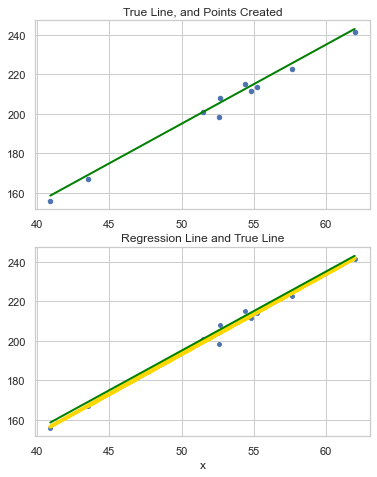

In [59]:
draw_and_compare(4, -5, 10)

Наши модели показывают, что если регрессионная модель работает, а размер выборки велик, то линия регрессии, скорее всего, будет близка к истинной линии. Это позволяет оценить наклон истинной линии.

Мы будем использовать наш знакомый пример матерей и их новорожденных детей для разработки метода оценки наклона истинной линии. Во-первых, давайте посмотрим, можно ли верить тому, что регрессионная модель является подходящим набором допущений для описания отношения между весом при рождении и количеством дней беременности.

In [60]:
baby = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/baby.csv')

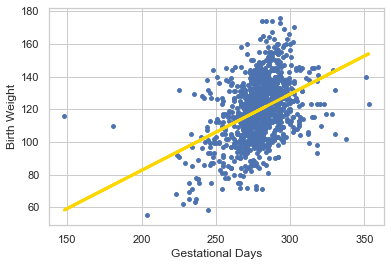

In [63]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')

In [64]:
correlation(baby, 'Gestational Days', 'Birth Weight')

0.40754279338885196

По большому счету, точки диаграммы довольно равномерно распределяются по линии, хотя есть несколько точек, которые разбросаны по краям основного облака. Корреляция составляет 0,4, а линия регрессии имеет положительный наклон.

Отражает ли это тот факт, что истинная линия имеет положительный наклон? Чтобы ответить на этот вопрос, давайте посмотрим, можно ли оценить истинный наклон. Конечно, у нас есть одна его оценка: наклон нашей линии регрессии. Это примерно 0,47 унций в день.

In [65]:
slope(baby, 'Gestational Days', 'Birth Weight')

0.4665568769492164

Но если бы точечная диаграмма была иной, линия регрессии также была бы иной и могла бы иметь иной наклон. Как определить, насколько иным мог бы быть наклон?

Нам нужна еще одна выборка точек, чтобы можно было нарисовать линию регрессии через новую точечную диаграмму и найти ее наклон. Но где взять еще одну выборку?

Вы угадали — мы *применим метод бутстрэп для исходного примера*. Это даст нам точечную диаграмму, на которой можно нарисовать линию регрессии.

## Создание точечной диаграммы методом бутстрэп
Мы можем имитировать новые выборки посредством выполнения случайной выборки с заменой из исходной выборки, число раз, равное размеру исходной выборки. Каждая из этих новых выборок даст нам точечную диаграмму. Мы назовем это точечной диаграммой, созданной методом бутстрэп, а весь процесс, для краткости, — бутстрэп-созданием точечной диаграммы.

Ниже приведена исходная точечная диаграмма из выборки и четыре репликации процедуры повторной выборки методом бутстрэп. Обратите внимание, что точечные диаграммы повторных выборок в общем случае немного более разрежены, по сравнению с оригиналом. Это связано с тем, что некоторые из исходных точек не попали в повторные выборки.

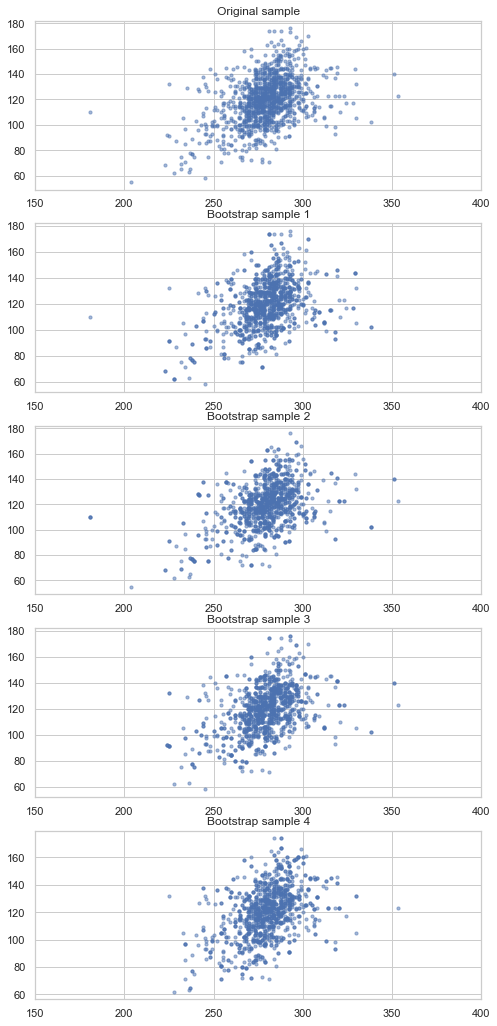

In [82]:
plt.figure(figsize=(8, 18))
plt.subplot(5, 1, 1)
plt.scatter(baby['Gestational Days'], baby['Birth Weight'], s=10, alpha=.5)
plt.xlim([150, 400])
plt.title('Original sample')

for i in np.arange(1, 5, 1):
    plt.subplot(5, 1, i+1)
    rep = baby.sample(frac=1, replace=True)
    plt.scatter(rep['Gestational Days'], rep['Birth Weight'], s=10, alpha=.5)
    plt.xlim([150, 400])
    plt.title('Bootstrap sample ' + str(i))

## Оценка истинного наклона
Можно создать большое число точечных диаграмм методом бутстрэп и провести линию регрессии через каждую созданную так диаграмму. Каждая из этих линий будет иметь наклон. Мы можем просто собрать все наклоны и нарисовать их эмпирическую гистограмму. Вспомним, что по умолчанию метод `sample` рисует случайным образом с заменой, число раз, соответствующее числу строк в таблице. То есть `sample` по умолчанию создает бутстрэп-выборку.

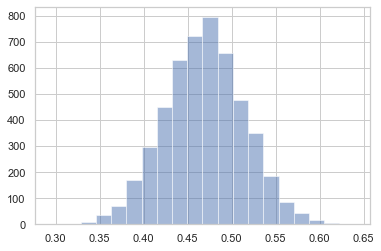

In [84]:
repetitions = 5000
slopes = np.zeros(repetitions)
for i in np.arange(repetitions):
    bootstrap_sample = baby.sample(frac=1, replace=True)
    bootstrap_slope = slope(bootstrap_sample, 'Gestational Days', 'Birth Weight')
    slopes[i] = bootstrap_slope
    
plt.hist(slopes, bins=20, alpha=.5);

Затем можно создать приблизительно 95-процентный доверительный интервал для наклона истинной линии с помощью процентного метода бутстрэп. Доверительный интервал простирается с 2,5-го процентиля до 97,5-го процентиля 5000 начальных наклонов, созданных методом бутстрэп.

In [85]:
left = np.percentile(slopes, 2.5)
right = np.percentile(slopes, 97.5)
left, right

(0.3815749553128027, 0.5563021631332175)

Приблизительно 95-процентный доверительный интервал для истинного наклона составляет около 0,38 унций в день до 0,56 унций в день.

## Функция для определения наклона методом бутстрэп
Давайте соберем все этапы нашего метода оценки наклона и определим функцию `bootstrap_slope`, которая их выполняет. Его аргументы — это имя таблицы и метки переменных предиктора и отклика, а также необходимое количество репликаций метода бутстрэп. При каждой репликации функция производит выборку методом бутстрэп для создания исходной точечной диаграммы и вычисляет наклон получающейся линии регрессии. Затем он создает гистограмму всех созданных наклонов и выводит интервал, состоящий из "средних 95%" наклонов.



In [86]:
def bootstrap_slope(table, x, y, repetitions):

    # For each repetition:
    # Bootstrap the scatter, get the slope of the regression line, augment the list of generated slopes
    slopes = np.zeros(repetitions)
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample(frac=1, replace=True)
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes[i] = bootstrap_slope

    # Find the endpoints of the 95% confidence interval for the true slope
    left = np.percentile(slopes, 2.5)
    right = np.percentile(slopes, 97.5)

    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)

    # Display results
    plt.hist(slopes, bins=20, alpha=.5)
    plt.plot(np.array([left, right]), np.array([0, 0]), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)

Когда мы вызываем `bootstrap_slope`, чтобы найти доверительный интервал для истинного наклона, где переменной ответа является вес при рождении, а предиктором — число дней беременности, мы получаем интервал, очень близкий к полученному ранее: от приблизительно 0,38 унций в день до 0,56 унций в день.

Slope of regression line: 0.4665568769492164
Approximate 95%-confidence interval for the true slope:
0.38157565245491804 0.5565676964655543


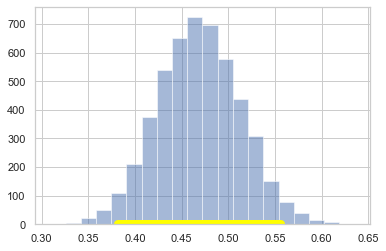

In [87]:
bootstrap_slope(baby, 'Gestational Days', 'Birth Weight', 5000)

Теперь, когда у нас есть функция, которая автоматизирует наш процесс оценки наклона истинной строки в регрессионной модели, мы можем использовать ее и для других переменных.

Например, давайте рассмотрим отношение между весом при рождении и ростом матери. Действительно ли дети более высоких женщин весят больше?

Регрессионная модель кажется разумной, исходя из точечной диаграммы, но уровень корреляции невысок. Всего около 0,2.

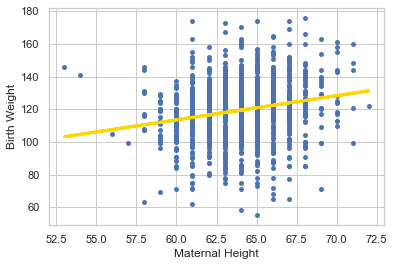

In [88]:
scatter_fit(baby, 'Maternal Height', 'Birth Weight')

In [89]:
correlation(baby, 'Maternal Height', 'Birth Weight')

0.20370417718968062

Как и ранее, `bootstrap_slope` можно использовать для оценки наклона истинной линии в регрессионной модели.


Slope of regression line: 1.4780193519284357
Approximate 95%-confidence interval for the true slope:
1.0471489885950958 1.9190577760380076


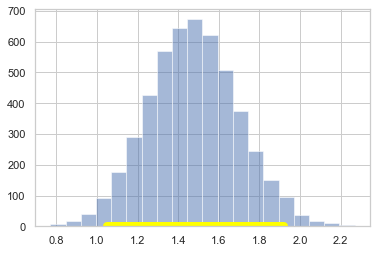

In [90]:
bootstrap_slope(baby, 'Maternal Height', 'Birth Weight', 5000)

Наш 95-процентный доверительный интервал для истинного наклона простирается от 1 до 1,9 унций на дюйм.

## Может ли истинный наклон иметь значение 0?
Предположим, мы убеждены, что наши данные соответствуют регрессионной модели, и мы используем линию регрессии для оценки реальной линии. Если линия регрессии не вполне плоская, как почти всегда и бывает, мы будем наблюдать некоторую линейную связь на точечной диаграмме.

Но что если результат нашего наблюдения является мнимым? Другими словами, что если истинная линия была плоской, т. е. линейной зависимости между двумя переменными не существовало, а отслеживаемая связь была обусловлена лишь случайностью расположения точек, образующих нашу выборку?

Ниже приведено моделирование, в котором показано, почему возникает этот вопрос. Снова будет вызвана функция, `draw_and_compare`, на этот раз требуется, чтобы истинная линия имела значение наклона 0. Наша цель — проверить, показывает ли линия регрессии наклон, отличный от 0.

Помните, что аргументы для функции `draw_and_compare` являются наклоном и отрезком, отсекаемым на координатной оси, истинной линии, плюс количеством создаваемых точек.

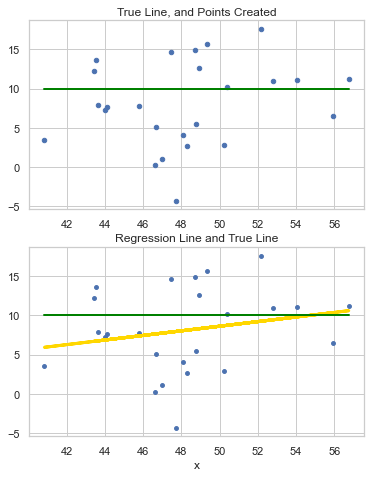

In [91]:
draw_and_compare(0, 10, 25)

Запустите моделирование несколько раз, сохраняя каждый раз значение 0 наклона истинной линии. Обратите внимание, что, хотя наклон истинной линии равен 0, наклон линии регрессии обычно не равен 0. Линия регрессии иногда уклоняется вверх, а иногда вниз, каждый раз создавая у нас ложное впечатление, что эти две переменные коррелируют.

Чтобы решить, является ли видимый нам наклон реальным, нам надо протестировать следующие гипотезы:

**Нулевая гипотеза.** Наклон истинной линии равен 0.

**Альтернативная гипотеза.** Наклон истинной линии не равен 0.

Для этого у нас есть все необходимое. Так как мы можем создать 95-процентный доверительный интервал для истинного наклона, все, что нужно сделать, — это определить, содержит ли данный интервал значение 0.

Если это не так, мы можем отклонить нулевую гипотезу (с уровнем отсечения 5 % для пи-значения).

Если доверительный интервал для истинного наклона содержит значение 0, то у нас нет достаточных доказательств, чтобы отклонить нулевую гипотезу. Возможно, что наклон, который мы наблюдаем, является мнимым.

Давайте используем этот метод в качестве примера. Предположим, что мы пытаемся оценить вес ребенка при рождении на основе возраста матери. На основе данной выборки наклон линии регрессии для оценки веса родившихся детей на основе возраста матери положителен, приблизительно 0,08 унции на год.

In [92]:
slope(baby, 'Maternal Age', 'Birth Weight')

0.08500766941582515

Хотя наклон положительный, он довольно мал. Линия регрессии настолько близка к плоской, что это вызывает вопрос, не является ли истинная линия плоской.

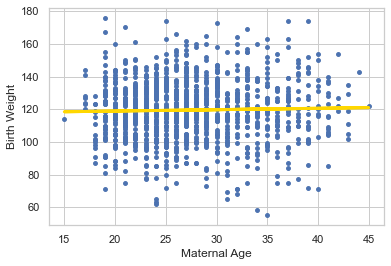

In [93]:
scatter_fit(baby, 'Maternal Age', 'Birth Weight')

Мы можем использовать `bootstrap_slope`, чтобы оценить наклон истинной линии. Вычисление показывает, что приблизительный 95-процентный доверительный интервал метода бутстрэпа для истинного наклона имеет отрицательную левую конечную точку и положительную правую конечную точку — иными словами, интервал содержит значение 0.

Slope of regression line: 0.08500766941582515
Approximate 95%-confidence interval for the true slope:
-0.10123793336079168 0.2723868823414333


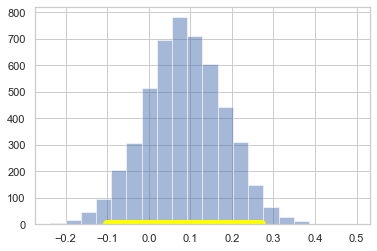

In [94]:
bootstrap_slope(baby, 'Maternal Age', 'Birth Weight', 5000)

Так как интервал содержит значение 0, мы не можем отклонить нулевую гипотезу, предполагающую, что наклон истинной линейной связи между возрастом матери и весом ребенка при рождении равен 0. На основе этого анализа было бы неразумно прогнозировать вес при рождении на основе регрессионной модели с возрастом матери в качестве предиктора.

# Интервалы прогнозирования

Одним из основных способов использования регрессии является создание прогнозов для нового лица, которое не было частью нашей исходной выборки, но похоже на вошедших в выборку лиц. На языке модели мы хотим оценить $y$ для нового значения $x$.

Наша оценка — это высота истинной линии в $x$. Конечно, мы не знаем истинной линии. Ее у нас заменяет линия регрессии через нашу выборку точек.

**Подобранное** значение при заданном значении $x$ — это оценка регрессии $y$ на основе этого значения $x$. Иными словами, подобранное значение при заданном значении $x$ является высотой линии регрессии в этой точке $x$.

Предположим, мы пытаемся спрогнозировать вес ребенка при рождении, в зависимости от количества дней беременности. Как было показано в предыдущем разделе, данные довольно хорошо соответствуют регрессионной модели и 95-процентный доверительный интервал для наклона истинной линии не содержит значения 0. Так что кажется разумным выполнение нашего прогноза.

На рисунке ниже показано, где прогноз находится на линии регрессии. Красная линия находится на $x = 300$.

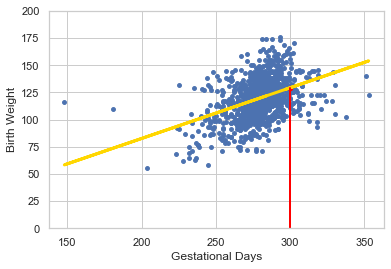

In [95]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')
s = slope(baby, 'Gestational Days', 'Birth Weight')
i = intercept(baby, 'Gestational Days', 'Birth Weight')
fit_300 = s * 300 + i
plt.scatter(300, fit_300, color='red', s=20)
plt.plot([300,300], [0, fit_300], color='red', lw=2)
plt.ylim([0, 200]);

Высота точки, где красная линия касается линии регрессии, является подобранным значением для 300 дней беременности.

Функция `fitted_value` вычисляет эту высоту. Как и в функциях `correlation`, `slope` и `intercept`, ее аргументы включают имя таблицы и метки столбцов $x$ и $y$. Но ей также требуется четвертый аргумент, являющийся значением $x$, для которого будет выполняться оценка.

In [96]:
def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

Подобранное значение для 300 дней беременности составляет примерно 129,2 унций. Иными словами, для беременности с длительностью в 300 дней наша оценка веса ребенка при рождении составляет около 129,2 унций.

In [97]:
fit_300 = fitted_value(baby, 'Gestational Days', 'Birth Weight', 300)
fit_300

129.21292417031435

## Вариативность прогноза
Мы разработали метод, создающий один прогноз веса ребенка при рождении в зависимости от количества дней беременности, используя данные из нашей выборки. Но, как специалисты по анализу данных, мы понимаем, что выборка могла бы отличаться. Если бы выборка была другой, линия регрессии тоже была бы другой, а следовательно, и наш прогноз. Чтобы увидеть, насколько хорош наш прогноз, необходимо понять, насколько он может варьироваться.

Для этого необходимо создать новые выборки. Это можно сделать путем использования метода бутстрэп для создания точечной диаграммы, как в предыдущем разделе. Затем мы сопоставим линию регрессии с точечной диаграммой в каждой репликации и выполним прогноз на основе каждой из линий. На рисунке ниже показаны 10 таких линий и соответствующий прогнозируемый вес при родах на 300 дне беременности.

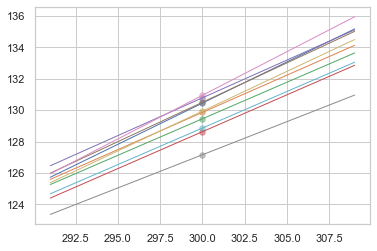

In [107]:
x = 300

lines = []
for i in range(10):
    rep = baby.sample(frac=1, replace=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

lines = pd.DataFrame(lines, columns=['slope','intercept'])
lines[f'prediction at x={x}'] = lines['slope'] * x + lines['intercept']

xlims = np.array([291, 309])
left = xlims[0] * lines['slope'] + lines['intercept']
right = xlims[1] * lines['slope'] + lines['intercept']
fit_x = x * lines['slope'] + lines['intercept']

for i in range(10):
    plt.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plt.scatter(x, fit_x[i], s=30, alpha=.5)

Прогнозы в разных строках отличаются. В таблице ниже показаны наклон и отсекаемый на координатной оси отрезок каждой из 10 линий, вместе с прогнозом.

In [108]:
lines

,slope,intercept,prediction at x=300
0,0.525754,-27.275271,130.450961
1,0.475058,-12.657719,129.859635
2,0.466383,-10.462405,129.452433
3,0.470628,-12.561552,128.626905
4,0.481737,-13.732697,130.788498
5,0.502660,-20.293140,130.504740
6,0.556725,-36.068419,130.949129
7,0.422965,0.265326,127.154866
8,0.507587,-22.337016,129.939102
9,0.466416,-11.063443,128.861234


## Интервал прогнозов метода бутстрэп
Если увеличить число повторений процесса повторной выборки, можно создать эмпирическую гистограмму прогнозов. Это позволит нам создать интервал прогнозов, используя тот же метод процентиля, который мы использовали для создания доверительного интервала методом бутстрэп для наклона.

Давайте определим для этого функцию с именем `bootstrap_prediction`. Функция принимает пять аргументов: — имя таблицы — заголовки столбцов для переменных предиктора и отклика, в этом порядке — значение $x$, на котором нужно сделать прогноз — требуемое количество повторений метода бутстрэп.

В каждом повторении функция применяет метод бутстрэп к исходной точечной диаграмме и находит прогнозируемое значение $y$ на основе указанного значения $x$. В частности, вызывается функция, `fitted_value`, которая была определена ранее в этом разделе, чтобы найти подобранное значение на заданном $x$.

Наконец, он выводит гистограмму со всеми прогнозируемыми значениями и интервал, состоящий из "средних 95 %" прогнозируемых значений. Он также выводит прогнозируемое значение на основе линии регрессии, проходящей через исходную точечную диаграмму.

In [113]:
# Bootstrap prediction of variable y at new_x
# Data contained in table; prediction by regression of y based on x
# repetitions = number of bootstrap replications of the original scatter plot

def bootstrap_prediction(table, x, y, new_x, repetitions):

    # For each repetition:
    # Bootstrap the scatter;
    # get the regression prediction at new_x;
    # augment the predictions list
    predictions = np.zeros(repetitions)
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample(frac=1, replace=True)
        bootstrap_prediction = fitted_value(bootstrap_sample, x, y, new_x)
        predictions[i] = bootstrap_prediction

    # Find the ends of the approximate 95% prediction interval
    left = np.percentile(predictions, 2.5)
    right = np.percentile(predictions, 97.5)

    # Prediction based on original sample
    original = fitted_value(table, x, y, new_x)

    # Display results
    plt.hist(predictions, bins=20, alpha=.5)
    plt.xlabel(f'predictions at x={new_x}')
    plt.plot(np.array([left, right]), np.array([0, 0]), color='yellow', lw=8);
    print(f'Height of regression line at x={new_x}:', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)

Height of regression line at x=300: 129.21292417031435
Approximate 95%-confidence interval:
127.23222555441896 131.29506328543943


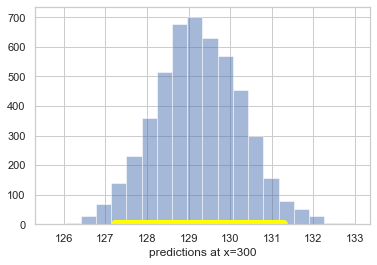

In [114]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 300, 5000)

На приведенном выше рисунке показана созданная методом бутстрэпа эмпирическая гистограмма для прогнозируемого веса ребенка при рождении на 300 дне беременности, основанная на повторении этого метода 5000 раз. Эмпирическое распределение является примерно нормальным.

Интервал прогнозирования в приблизительно 95% оценок был создан путем взятия "средних 95%" прогнозов, то есть интервала от 2,5-го процентиля до 97,5-го процентиля прогнозов. В этом интервале находятся значения от примерно 127 до примерно 131. Прогноз, основанный на исходной выборке, составил примерно 129, что близко к центру интервала.

## Результат изменения значения предиктора
На рисунке ниже показана гистограмма с 5000 бутстрэп-прогнозами для 285 дней беременности. Прогноз на основе исходной выборки составляет около 122 унций, с интервалом от примерно 121 унции до 123 унций.

Height of regression line at x=285: 122.2145710160761
Approximate 95%-confidence interval:
121.18735509894123 123.29377621445578


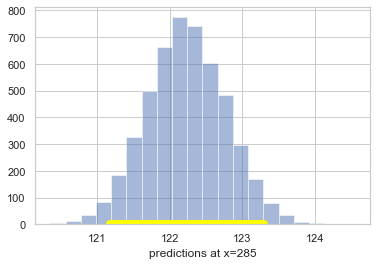

In [115]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 285, 5000)

Обратите внимание на то, что этот интервал является более узким, чем интервал прогнозирования для 300 дней беременности. Давайте рассмотрим причину этого.

Среднее число дней беременности составляет примерно 279 дней.

In [116]:
baby['Gestational Days'].mean()

279.1013628620102

Таким образом, 285 находится ближе к центру распределения, чем 300. Обычно линии регрессии, основанные на бутстрэп-образцах, расположены ближе друг к другу в центре распределения переменной прогнозирования. Поэтому все прогнозируемые значения также расположены ближе друг к другу. Это объясняет более узкий интервал прогнозирования.

Это можно увидеть на рисунке ниже, который показывает прогнозы на $x=285$ и $x=300$ для каждой из десяти репликаций метода бутстрэп. Как правило, строки находятся дальше друг от друга в $x=300$, чем в $x=285$, и поэтому прогнозы для $x=300$ варьируются сильнее.

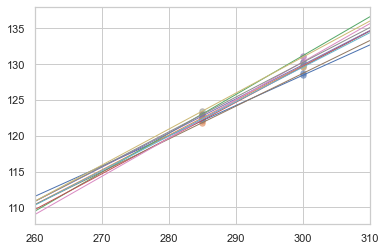

In [118]:
x1 = 300
x2 = 285

lines = []
for i in range(10):
    rep = baby.sample(frac=1, replace=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

lines = pd.DataFrame(lines, columns=['slope','intercept'])

xlims = np.array([260, 310])
left = xlims[0] * lines['slope'] + lines['intercept']
right = xlims[1] * lines['slope'] + lines['intercept']
fit_x1 = x1 * lines['slope'] + lines['intercept']
fit_x2 = x2 * lines['slope'] + lines['intercept']

plt.xlim(xlims)
for i in range(10):
    plt.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plt.scatter(x1, fit_x1[i], s=30, alpha=.5)
    plt.scatter(x2, fit_x2[i], s=30, alpha=.5)

## Предостережение
Все прогнозы и тесты, выполненные в этой главе, предполагают, что регрессионная модель работает. В частности, методы предполагают, что точечная диаграмма похожа на точки, созданные начиная с точек на прямой, с последующим помещением точек за пределами линии, путем добавления случайного обычного шума.

Если точечная диаграмма не выглядит подобным образом, то, возможно, модель не соответствует изучаемым данным. Если модель не работает, то вычисления, предполагающие ее истинность, недопустимы.

Поэтому сначала необходимо решить, работает ли регрессионная модель для наших данных, а уж затем приступать к прогнозам на основе модели или проверке гипотез о параметрах модели. Простой способ для этого — сделать то, что мы сделали в этом разделе, то есть нарисовать точечную диаграмму двух переменных и определить, выглядит ли она приблизительно линейно, с равномерным разбросом вокруг линии. Также следует выполнить диагностику, разработанную в предыдущем разделе, используя остаточную диаграмму.